## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [2]:
%matplotlib inline

In [3]:
# библиотека для работы с данными
import pandas as pd

# для EDA анализа
import ydata_profiling

# библиотека для математических вычислений
import numpy as np

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# модуль для проверки гипотез
from scipy import stats as st

## 2 Открытие файлов с данными и изучение общей информации
### 2.1 Звонки
Считаем данные из csv-файла в датафрейм, сохраним в переменную `calls` и проведём EDA анализ.

In [14]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv')
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv')
    ydata_profiling.ProfileReport(df, progress_bar=False, correlations={"auto": {"calculate": False}})\
    .to_file(name + '.html')
    return df

In [15]:
calls = read_eda('calls')

[Посмотреть анализ.](https://www.dropbox.com/s/37wbc90i1bwduyq/calls.html?dl=0)

- **Обнаружен некорректный тип столбца `call_date`.**
- **На графике заметно распределение Пуассона.**

### 2.2 Интернет-сессии
Считаем данные из csv-файла в датафрейм, сохраним в переменную `sessions` и проведём EDA анализ.

In [16]:
sessions = read_eda('sessions')

[Посмотреть анализ.](https://www.dropbox.com/s/htu40sh3ess22dq/sessions.html?dl=0)

- **Присутствует столбец `Unnamed: 0`, дублирующий индексы.**
- **Обнаружен некорректный тип столбца `session_date`.**
- **На графике также заметно распределение Пуассона.**

### 2.3 Cообщения
Считаем данные из csv-файла в датафрейм, сохраним в переменную `messages` и проведём EDA анализ.

In [17]:
messages = read_eda('messages')

[Посмотреть анализ.](https://www.dropbox.com/s/3t5rsh42waa3n26/messages.html?dl=0)

**Обнаружен некорректный тип столбца `message_date`.**

### 2.4 Тарифы
Считаем данные из csv-файла в датафрейм, сохраним в переменную `tariffs` и проведём EDA анализ.

In [18]:
tariffs = read_eda('tariffs')

[Посмотреть анализ.](https://www.dropbox.com/s/kjukdbm2b4fhj0o/tariffs.html?dl=0)

**Проблем не обнаружено.**

### 2.5 Пользователи
Считаем данные из csv-файла в датафрейм, сохраним в переменную `users` и проведём EDA анализ.

In [19]:
users = read_eda('users')

[Посмотреть анализ.](https://www.dropbox.com/s/i9l6uoo9usw2iae/users.html?dl=0)

**Обнаружен некорректный тип столбца `reg_date`.**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Данные, подлежащие обработке:</b>
        <li>Типы столбцов с датами;</li>
        <li>Столбец, дублирующий индексы.</li>
    </p>  
</div>

## 3 Предобработка данных
### 3.1 Изменение типов данных
Приведём столбцы с датами к типу `datetime`.

In [20]:
for df in [users, calls, messages, sessions]:
    for column in df.columns:
        if 'date' in column:
            df[column] = pd.to_datetime(df[column])

В датафрейме `calls` в столбце `duration` есть звонки с нулевой продолжительностью, думаю, это пропущенные звонки. Для удобства округлим значения этого столбца вверх и приведём к типу `int`.

In [21]:
calls['duration'] = np.ceil(calls['duration']).astype(int)

### 3.2 Работа со столбцами
В датафрейме `sessions` есть столбец `Unnamed: 0`, дублирующий индексы (такое возникает, когда данные сохраняют с указанием индекса), удалим его.

In [22]:
sessions = sessions.drop('Unnamed: 0', axis=1)

Создадим столбцы `month` с номерами месяцев из столбцов с датами в датафреймах `calls`, `messages` и `sessions`.

In [23]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
sessions['month'] = sessions['session_date'].dt.month

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты обработки данных:</b>
        <ol>
        <li>Изменены типы данных.</li>
        <li>Удалён столбец "Unnamed: 0", дублирующий индексы датафрейма "sessions".</li>
        <li>Добавлены новые столбцы с номерами месяцев в датафреймы "calls", "messages" и "sessions".</li>
        </ol>
   </p>  
</div>

## 3 Создание новых датафреймов
Посчитаем количество сделанных звонков разговора для каждого пользователя по месяцам и сохраним в переменную `calls_per_month`.

In [24]:
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))
calls_per_month.head(10)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63

Посчитаем количество израсходованных минут разговора для каждого пользователя по месяцам и сохраним в переменную `minutes_per_month`.

In [25]:
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))
minutes_per_month.head(10)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414

Посчитаем количество отправленных сообщений по месяцам для каждого пользователя и сохраним в переменную `messages_per_month`.

In [26]:
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))
messages_per_month.head(10)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11

Посчитаем количество потраченных мегабайт по месяцам для каждого пользователя и сохраним в переменную `sessions_per_month`.

In [27]:
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})
sessions_per_month.head(10)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66

Объединим все посчитанные выше значения в один датафрейм `user_behavior`.
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [28]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице `user_behavior` после объединения.

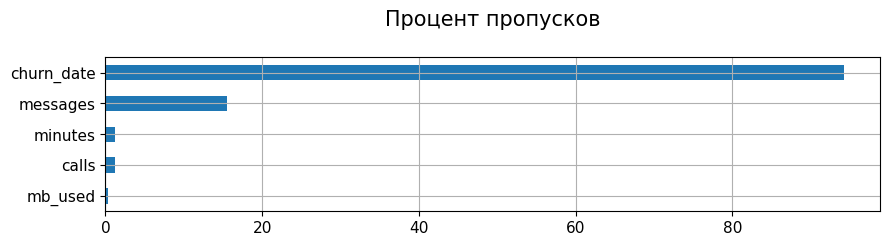

In [29]:
try:
    (
        (user_behavior.isna().mean()*100)
        .to_frame()
        .rename(columns={0:'space'})
        .query('space > 0')
        .sort_values(by='space', ascending=True)
        .plot(kind='barh', figsize=(10, 2), legend=False, fontsize=11, grid=True)
        .set_title('Процент пропусков' + "\n", fontsize=15)    
    );    
except:
    print('Пропусков нет.')

Заполним образовавшиеся пропуски в данных нолями.

In [30]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Присоединим информацию о тарифах.

In [31]:
tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)
user_behavior = user_behavior.merge(tariffs, on='tariff')

Посчитаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф.

In [32]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Переведём превышающие тариф мегабайты в гигабайты и сохраним в столбец `paid_gb`.

In [33]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Посчитаем выручку за минуты разговора, сообщения и интернет.

In [34]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Посчитаем помесячную выручку с каждого пользователя и сохраним в столбец `total_cost`.

In [35]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

Создадим датафрейм `stats_df`, в котором будут храниться основные характеристики для каждой пары "месяц-тариф".

In [36]:
stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head()

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0


<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Было создано 2 датафрейма:</b>
        <li>"user_behavior", где для каждой пары "пользователь - месяц" доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.</li>
        <li>"stats_df", в котором хранятся основные характеристики для каждой пары "месяц-тариф".</li>
   </p>  
</div>

## 4 Исследовательский анализ данных
Посмотрим, какой процент клиентов расторг договор.

In [37]:
print('Договор расторгли ', 
      users['churn_date'].count() / users['churn_date'].shape[0] * 100, '% клиентов.', sep='')

Договор расторгли 7.6% клиентов.


Выведем распределение среднего количества звонков по видам тарифов и месяцам, а также сравнительную гистограмму тарифов по количеству звонков.

In [38]:
def bar_hist(y_column, column, title='количества', ylabel='Среднее количество', 
             xlabel='Количество', by=' звонков'):
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x='month', 
                     y=y_column,
                     hue="tariff",
                     data=stats_df,
                     palette=['silver', 'tab:blue'])

    ax.set_title('Распределение ' + title + by + ' по тарифам и месяцам' + "\n", size=15)
    plt.xlabel('Номер месяца', size=12) 
    plt.ylabel(ylabel + by, size=12)
    ax.grid()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    user_behavior[user_behavior['tariff'] =='smart'][column].hist(bins=35, alpha=0.5, color='gray')
    user_behavior[user_behavior['tariff'] =='ultra'][column].hist(bins=35, alpha=0.5, color='tab:blue')
    plt.legend(['Smart', 'Ultra'], prop={'size': 12})
    plt.title('Сравнительная гистограмма ' + title + by + ' по тарифам' + "\n", size=15)
    plt.xlabel(xlabel + by, size=12)
    plt.ylabel('Количество клиентов', size=12)
    plt.show()

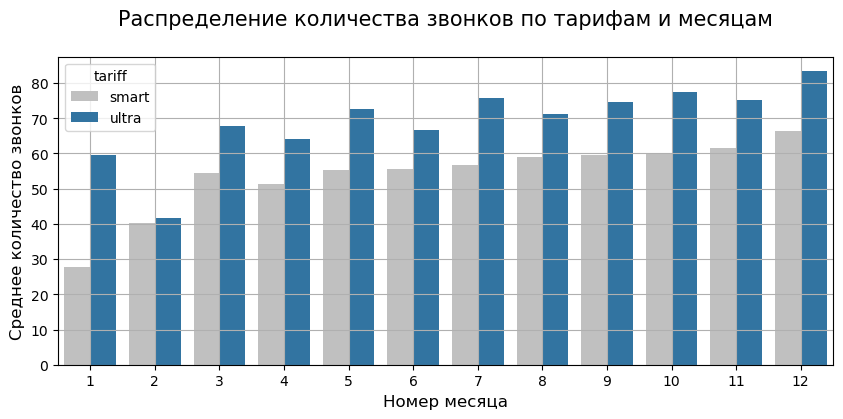

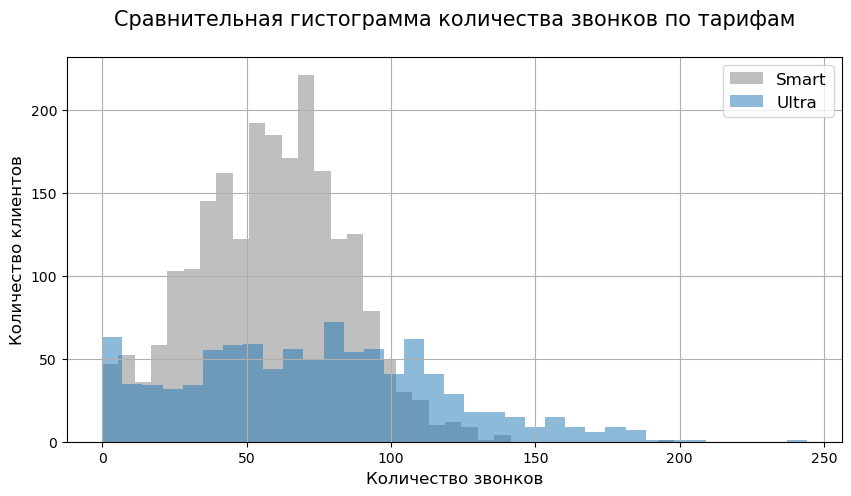

In [39]:
bar_hist(y_column='calls_mean', column='calls')

Выведем распределение средней продолжительности звонков по видам тарифов и месяцам, а также сравнительную гистограмму тарифов по продолжительности звонков.

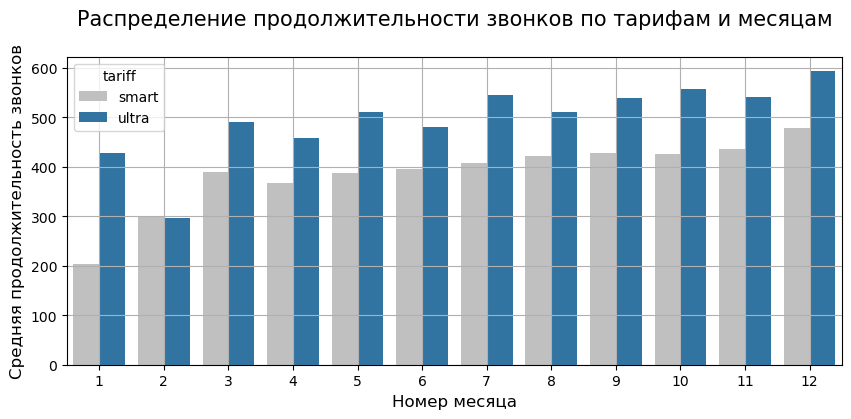

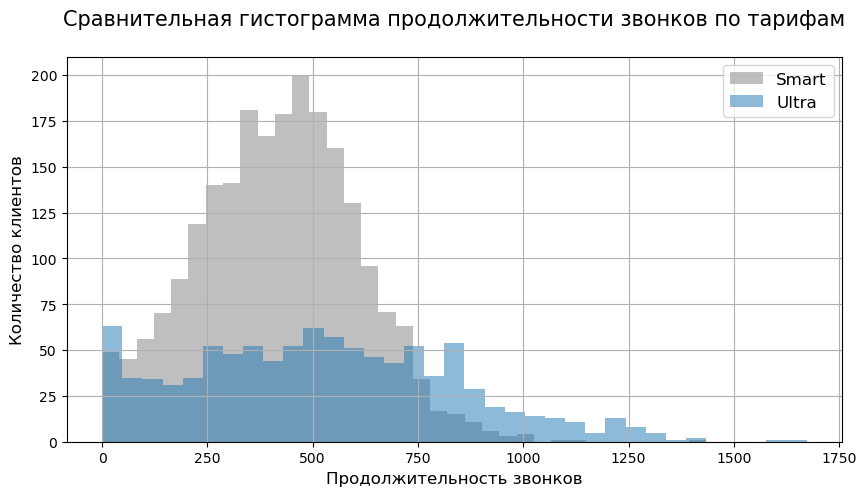

In [40]:
bar_hist(y_column='minutes_mean', title='продолжительности', ylabel='Средняя продолжительность', 
         column='minutes', xlabel='Продолжительность')

- **Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart.**
- **В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров.**
- **Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности.**
- **В феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.**

Выведем распределение среднего количества сообщений по видам тарифов и месяцам, а также сравнительную гистограмму тарифов по количеству сообщений.

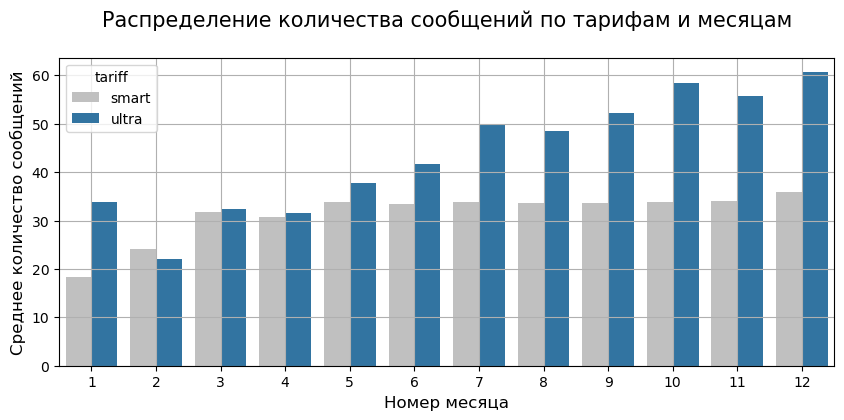

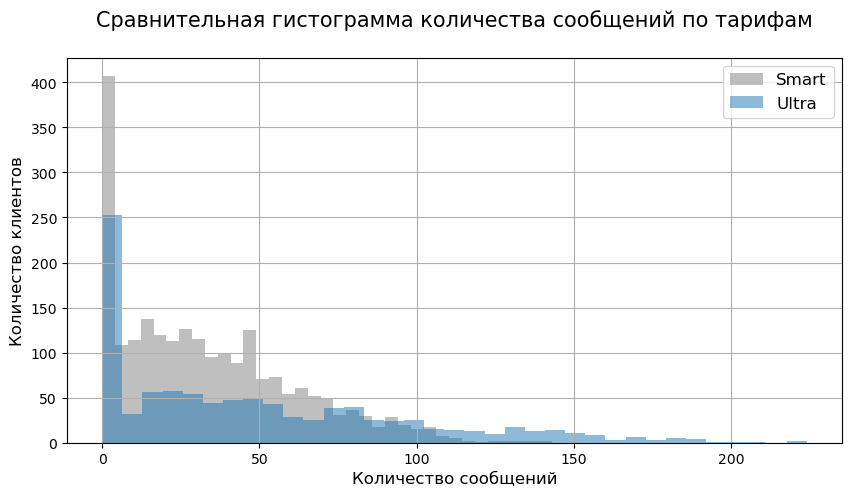

In [41]:
bar_hist(y_column='messages_mean', column='messages', by=' сообщений')

- **В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart.**
- **Количество сообщений в течение года на обоих тарифак растет.** 
- **Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.**

Выведем распределение среднего количества мегабайт по видам тарифов и месяцам, а также сравнительную гистограмму тарифов по количеству потраченных мегабайт.

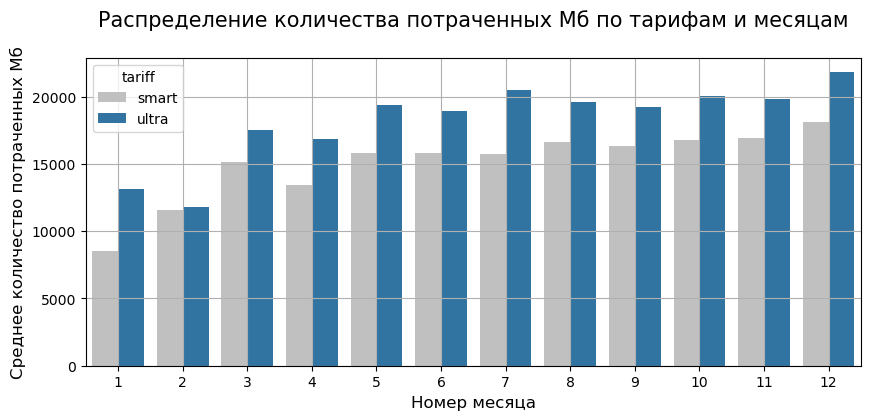

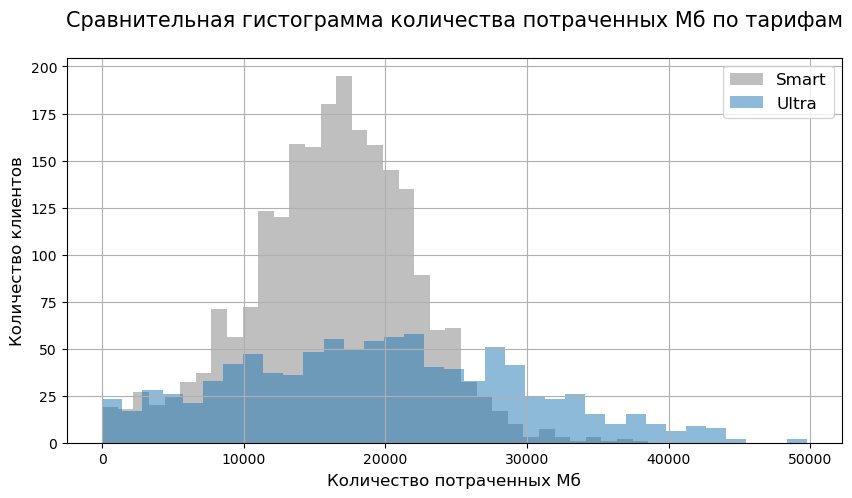

In [42]:
bar_hist(y_column='sessions_mean', column='mb_used', by=' потраченных Мб')

- **Меньше всего пользователи использовали интернет в январе, феврале и апреле.**
- **Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.**

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты исследовательского анализа:</b>
        <li>Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart.</li>
        <li>В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров.</li>
        <li>Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности.</li>
        <li>В феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.</li>
        <li>В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart.</li>
        <li>Количество сообщений в течение года на обоих тарифак растет.</li>
        <li>Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.</li>
        <li>Меньше всего пользователи использовали интернет в январе, феврале и апреле.</li>
        <li>Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.</li>
   </p>  
</div>

## 5 Проверка гипотез
### 5.1 Средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается
```
H_0: Выручка пользователей "Ультра" = выручка пользователей "Смарт"`
H_a: Выручка пользователей "Ультра" ≠ выручка пользователей "Смарт"`
```
Так как надо проверить гипотезу о равенстве среднего двух генеральных совокупностей, будем использовать метод `scipy.stats.ttest_ind()`.

In [43]:
results = st.ttest_ind(
    user_behavior[user_behavior['tariff'] =='ultra']['total_cost'], 
    user_behavior[user_behavior['tariff'] =='smart']['total_cost'], equal_var=False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

4.2606313931076085e-250
Отвергаем нулевую гипотезу


### 5.2 Средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов
```
H_0: Выручка пользователей из Москвы = выручка пользователей не из Москвы`
H_1: Выручка пользователей из Москвы ≠ выручка пользователей не из Москвы`
```
Так как надо проверить гипотезу о равенстве среднего двух генеральных совокупностей, будем использовать метод `scipy.stats.ttest_ind()`.

In [44]:
results = st.ttest_ind(
    user_behavior[user_behavior['city'] =='Москва']['total_cost'], 
    user_behavior[user_behavior['city'] !='Москва']['total_cost'], equal_var=False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Результаты проверки гипотез:</b>
        <li>Не отвергаем гипотезу о том, что средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается.</li>
        <li>Отвергаем гипотезу о том, что средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов.</li>
    </p>
</div>

## 6 Общий вывод

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Проделано:</b>
        <ol><li>Изучена общая информацию о данных.</li>
        <li>Проведена предподготовка данных: изменены типы данных, удалены и добавлены столбцы.</li>
        <li>Созданы новые датафреймы.</li>
        <li>Проведён исследовательский анализ данных.</li>
        <li>Проверены гипотезы.</li>
        </ol>
        <b>Выявлено:</b>
        <li>Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart.</li>
        <li>В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров.</li>
        <li>Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности.</li>
        <li>В феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.</li>
        <li>В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart.</li>
        <li>Количество сообщений в течение года на обоих тарифак растет.</li>
        <li>Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.</li>
        <li>Меньше всего пользователи использовали интернет в январе, феврале и апреле.</li>
        <li>Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.</li>
        <li>Не отвергаем гипотезу о том, что средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается.</li>
        <li>Отвергаем гипотезу о том, что средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов.</li><br>
        <b>Рекомендация: Ultra — лучший тариф.</b>
   </p>  
</div>